In [1]:
# importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import duckdb, sqlalchemy

In [2]:
%load_ext sql

%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

%sql duckdb:///:memory:

In [3]:
csv = pd.read_csv("bluejay_df.csv")

In [110]:
species_limited_df = pd.DataFrame(csv)
species_limited_df.head()

,Unnamed: 0,loc_id,subnational1_code,month,day,year,day1_am,day1_pm,day2_am,day2_pm,snow_dep_atleast,species_code,how_many,plus_code,valid
0,0,L6731705,US-NY,11,14,2020,1,1,1,1,0.0,blujay,1,NaN,1
1,1,L6731705,US-NY,11,14,2020,1,1,1,1,0.0,blujay,0,NaN,1
2,2,L6731705,US-NY,11,14,2020,1,1,1,1,0.0,blujay,0,NaN,1
3,3,L6731705,US-NY,11,14,2020,1,1,1,1,0.0,blujay,0,NaN,1
4,4,L6731705,US-NY,11,14,2020,1,1,1,1,0.0,blujay,0,NaN,1


In [111]:
species_limited_df.drop(['Unnamed: 0'],  axis= 1, inplace= True)

In [112]:
species_limited_df.head()

,loc_id,subnational1_code,month,day,year,day1_am,day1_pm,day2_am,day2_pm,snow_dep_atleast,species_code,how_many,plus_code,valid
0,L6731705,US-NY,11,14,2020,1,1,1,1,0.0,blujay,1,NaN,1
1,L6731705,US-NY,11,14,2020,1,1,1,1,0.0,blujay,0,NaN,1
2,L6731705,US-NY,11,14,2020,1,1,1,1,0.0,blujay,0,NaN,1
3,L6731705,US-NY,11,14,2020,1,1,1,1,0.0,blujay,0,NaN,1
4,L6731705,US-NY,11,14,2020,1,1,1,1,0.0,blujay,0,NaN,1


In [113]:
species_translate_df = pd.DataFrame(pd.read_csv("PFW-species-translation-table.csv"))
%sql species_limited_df << SELECT loc_id, subnational1_code, month, day, year, species_limited_df.species_code, how_many, valid, day1_am, day1_pm, day2_am, day2_pm, snow_dep_atleast, american_english_name AS species_name FROM species_limited_df INNER JOIN species_translate_df ON species_limited_df.species_code = species_translate_df.species_code;

Returning data to local variable species_limited_df


In [114]:
species_limited_df.head()

,loc_id,subnational1_code,month,day,year,species_code,how_many,valid,day1_am,day1_pm,day2_am,day2_pm,snow_dep_atleast,species_name
0,L6731705,US-NY,11,14,2020,blujay,1,1,1,1,1,1,0.0,Blue Jay
1,L6731705,US-NY,11,14,2020,blujay,0,1,1,1,1,1,0.0,Blue Jay
2,L6731705,US-NY,11,14,2020,blujay,0,1,1,1,1,1,0.0,Blue Jay
3,L6731705,US-NY,11,14,2020,blujay,0,1,1,1,1,1,0.0,Blue Jay
4,L6731705,US-NY,11,14,2020,blujay,0,1,1,1,1,1,0.0,Blue Jay


In [115]:
# dropping rows where snow depth was null
species_limited_df = species_limited_df.dropna(subset=['snow_dep_atleast'])

# creating new category with string corresponding to each value in snow depth (for binning in the line plots)
species_limited_df['snow_category'] = 'No_Snow'
species_limited_df.loc[species_limited_df['snow_dep_atleast'] == 0.001, 'snow_category'] = 'Light_Snow'
species_limited_df.loc[species_limited_df['snow_dep_atleast'] == 5.000, 'snow_category'] = '5 to 15 cm'
species_limited_df.loc[species_limited_df['snow_dep_atleast'] == 15.001, 'snow_category'] = 'Heavy_Snow'

In [116]:
snow_dummies = pd.get_dummies(species_limited_df['snow_category'], drop_first=True)
species_limited_df = pd.concat([species_limited_df, snow_dummies], axis=1)
species_limited_df.drop(['snow_category', 'snow_dep_atleast'],  axis= 1, inplace= True)
species_limited_df.head()

,loc_id,subnational1_code,month,day,year,species_code,how_many,valid,day1_am,day1_pm,day2_am,day2_pm,species_name,Heavy_Snow,Light_Snow,No_Snow
0,L6731705,US-NY,11,14,2020,blujay,1,1,1,1,1,1,Blue Jay,0,0,1
1,L6731705,US-NY,11,14,2020,blujay,0,1,1,1,1,1,Blue Jay,0,0,1
2,L6731705,US-NY,11,14,2020,blujay,0,1,1,1,1,1,Blue Jay,0,0,1
3,L6731705,US-NY,11,14,2020,blujay,0,1,1,1,1,1,Blue Jay,0,0,1
4,L6731705,US-NY,11,14,2020,blujay,0,1,1,1,1,1,Blue Jay,0,0,1


In [117]:
# create a column that puts month, date, year in one string
species_limited_df['datestring'] = species_limited_df['month'].astype(str) + "/" + species_limited_df['day'].astype(str) + "/" + species_limited_df['year'].astype(str)

#turn datestring into datetime and drop datestring
species_limited_df['date_time'] = pd.to_datetime(species_limited_df['datestring'], format='%m/%d/%Y')
species_limited_df = species_limited_df.drop(columns=["datestring"])
species_limited_df.head()

,loc_id,subnational1_code,month,day,year,species_code,how_many,valid,day1_am,day1_pm,day2_am,day2_pm,species_name,Heavy_Snow,Light_Snow,No_Snow,date_time
0,L6731705,US-NY,11,14,2020,blujay,1,1,1,1,1,1,Blue Jay,0,0,1,2020-11-14
1,L6731705,US-NY,11,14,2020,blujay,0,1,1,1,1,1,Blue Jay,0,0,1,2020-11-14
2,L6731705,US-NY,11,14,2020,blujay,0,1,1,1,1,1,Blue Jay,0,0,1,2020-11-14
3,L6731705,US-NY,11,14,2020,blujay,0,1,1,1,1,1,Blue Jay,0,0,1,2020-11-14
4,L6731705,US-NY,11,14,2020,blujay,0,1,1,1,1,1,Blue Jay,0,0,1,2020-11-14


In [118]:
# reading in raw provided data
csv_sites = pd.read_csv("PFW_count_site_data_public_2021.csv")

#creating dataframe
sites_df = pd.DataFrame(csv_sites)

# keeping only the columns that will be involved in analysis
sites_df = sites_df[['loc_id', 'proj_period_id', 'yard_type_pavement', 'yard_type_garden', 'yard_type_landsca', 'yard_type_woods', 
'yard_type_desert','hab_dcid_woods', 'hab_evgr_woods', 'hab_mixed_woods', 'hab_orchard', 'hab_park', 'hab_water_fresh', 
'hab_water_salt', 'hab_residential','hab_industrial', 'hab_agricultural', 'hab_desert_scrub', 'hab_young_woods', 'hab_swamp', 
'hab_marsh', 'brsh_piles_atleast', 'water_srcs_atleast', 'bird_baths_atleast', 'nearby_feeders', 'squirrels', 'cats', 'dogs', 'humans',
'housing_density', 'population_atleast']]

sites_df.head()

,loc_id,proj_period_id,yard_type_pavement,yard_type_garden,yard_type_landsca,yard_type_woods,yard_type_desert,hab_dcid_woods,hab_evgr_woods,hab_mixed_woods,...,brsh_piles_atleast,water_srcs_atleast,bird_baths_atleast,nearby_feeders,squirrels,cats,dogs,humans,housing_density,population_atleast
0,L100016,PFW_2002,0.0,0.0,1.0,0.0,0.0,1.0,NaN,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0
1,L100016,PFW_2003,0.0,0.0,1.0,0.0,0.0,1.0,NaN,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,1.0
2,L100016,PFW_2004,0.0,0.0,1.0,0.0,0.0,1.0,NaN,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,1.0
3,L100016,PFW_2005,0.0,0.0,1.0,0.0,0.0,1.0,NaN,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,1.0
4,L100016,PFW_2006,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,1.0


In [122]:
%sql join_df << SELECT month, day, year, species_limited_df.loc_id, species_code, species_name, how_many, date_time, day1_am, day1_pm, day2_am, day2_pm, Light_Snow, Heavy_Snow, No_Snow, proj_period_id, yard_type_pavement, yard_type_garden, yard_type_landsca, yard_type_woods, yard_type_desert,hab_dcid_woods, hab_evgr_woods, hab_mixed_woods, hab_orchard, hab_park, hab_water_fresh, hab_water_salt, hab_residential,hab_industrial, hab_agricultural, hab_desert_scrub, hab_young_woods, hab_swamp, hab_marsh, brsh_piles_atleast, water_srcs_atleast, bird_baths_atleast, nearby_feeders, squirrels, cats, dogs, humans, housing_density, population_atleast, FROM species_limited_df INNER JOIN sites_df ON species_limited_df.loc_id = sites_df.loc_id;

Returning data to local variable join_df


In [123]:
join_df.head()

,month,day,year,loc_id,species_code,species_name,how_many,date_time,day1_am,day1_pm,...,brsh_piles_atleast,water_srcs_atleast,bird_baths_atleast,nearby_feeders,squirrels,cats,dogs,humans,housing_density,population_atleast
0,4,24,2021,L10011987,blujay,Blue Jay,0,2021-04-24,1,0,...,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,2.0,5001.0
1,4,24,2021,L10011987,blujay,Blue Jay,0,2021-04-24,1,0,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,2.0,5001.0
2,1,30,2021,L10012113,blujay,Blue Jay,0,2021-01-30,1,0,...,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,3.0,5001.0
3,4,29,2021,L10049605,blujay,Blue Jay,0,2021-04-29,1,1,...,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,3.0,25001.0
4,4,29,2021,L10049605,blujay,Blue Jay,0,2021-04-29,1,1,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,3.0,25001.0


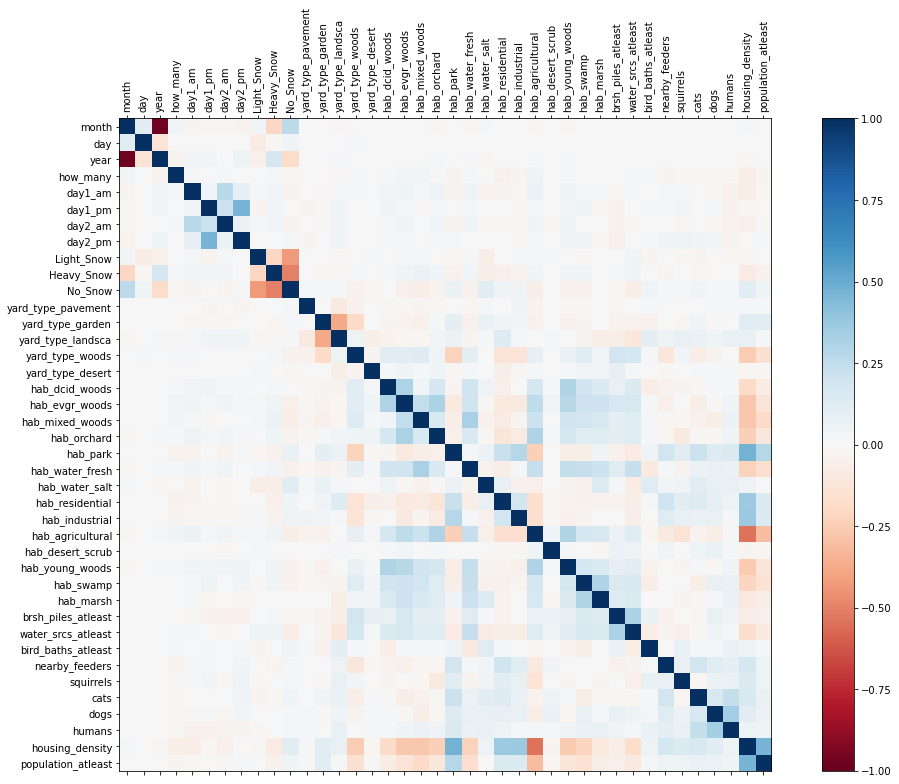

In [124]:
corr = join_df.corr()

fig = plt.figure()
fig.set_size_inches(18, 12)
ax = fig.add_subplot() 
fig.colorbar(ax.matshow(corr, cmap='RdBu', vmin=-1, vmax=1)) 

ax.set_xticks(range(len(corr.columns))) 
ax.set_xticklabels(corr.columns)
for tick in ax.get_xticklabels(): 
        tick.set_rotation(90)

ax.set_yticks(range(len(corr.columns))) 
ax.set_yticklabels(corr.columns)

plt.show()